# I-24 MOTION Tutorial
# Virtual trajectories for I-24 MOTION: data and tools

In this session, the tutorial will guide you through:
 1. how to generate macroscopic mean speed from the raw data?
2. how to smooth and interpolate the macroscopic data based on Adaptive Smoothing Method?
3. how to use the macroscopic speed field to generate virtual trajectories?

All the details of this session can be found at our Virtual Trajectory paper. 

**Ji, J., Wang, Y., Gloudemans, D., Zachár, G., Barbour, W., & Work, D. B. (2024, February). Virtual Trajectories for I–24 MOTION: Data and Tools. In 2024 Forum for Innovative Sustainable Transportation Systems (FISTS) (pp. 1-6). IEEE.**

<img src="figures/4lane_w_vts.png" width="1800"/>

## Directory structure
```
├── data_demo
│   ├── INCEPTION.22-11-22.tutorial.json
├── VT_tutorial
│   ├── vt_tutorial.ipynb
```

# Part 1: how to generate the macroscopic mean speed field?
Macroscopic mean speed field refers to the aggregated speed of the time and space based on trajectory data.
Data for test and tutorial here is actually a 10-minute data extracted from Nov 22, 2022. 

In [1]:
from macro_data_processing import get_speed_mean_field
from macro_data_processing import convert_to_cst_unix
import warnings
import time
starttime = convert_to_cst_unix('2022-11-22 07:20')
endtime = convert_to_cst_unix('2022-11-22 07:30')
input_filename = "../data_demo/INCEPTION.22-11-22.tutorial.json"

# dx and dt are the size of edie's box
dx = 0.02
dt = 4
lane_number = 1
t0 = time.time()

# Ignore an expected divide by zero error
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    speed_raw = get_speed_mean_field(input_filename, dx, dt, starttime, endtime, lane_number)
print(f"Speed field compute time: {time.time() - t0}s")
# speed_raw_df here is a DataFrame, with 3 columns, saying t, x, speed.
# t refers to the time index and x refers to the space index.
# index here means the number of the time or space of the space-time state by the dt or dx
# real time = t*dt + starttime
# real milemarker = x*dx + min_milemarker (58.7 in our case)

41196it [00:33, 1233.78it/s]

Speed field compute time: 33.41247892379761s


To understand how the macroscopic mean speed field is calculated using Edie's definition and why the diamond/non-rectangular cell is more recommended, readers can go to the following references for more details.

### References
[1] L. C. Edie et al., Discussion of traffic stream measurements and definitions. Port of New York Authority New York, 1963

[2] Z. He, Y. Lv, L. Lu, and W. Guan, Constructing spatiotemporal speed contour diagrams: using rectangular or non-rectangular parallelogram cells? Transportmetrica B: transport dynamics, 2017

[3] Treiber, M. Traffic dynamics and simulation, Class Slides: https://www.mtreiber.de/Vkmod/index.html, Lecture 1, 2023

<img src="figures/diamond_edie.png" alt="Diamond Edie" width="2000"/>

In [2]:
from visualization import visualize_heatmap

In [3]:
speed_raw['time'] = speed_raw['t'] * dt
speed_raw['milemarker'] = speed_raw['x'] * dx + 58.7

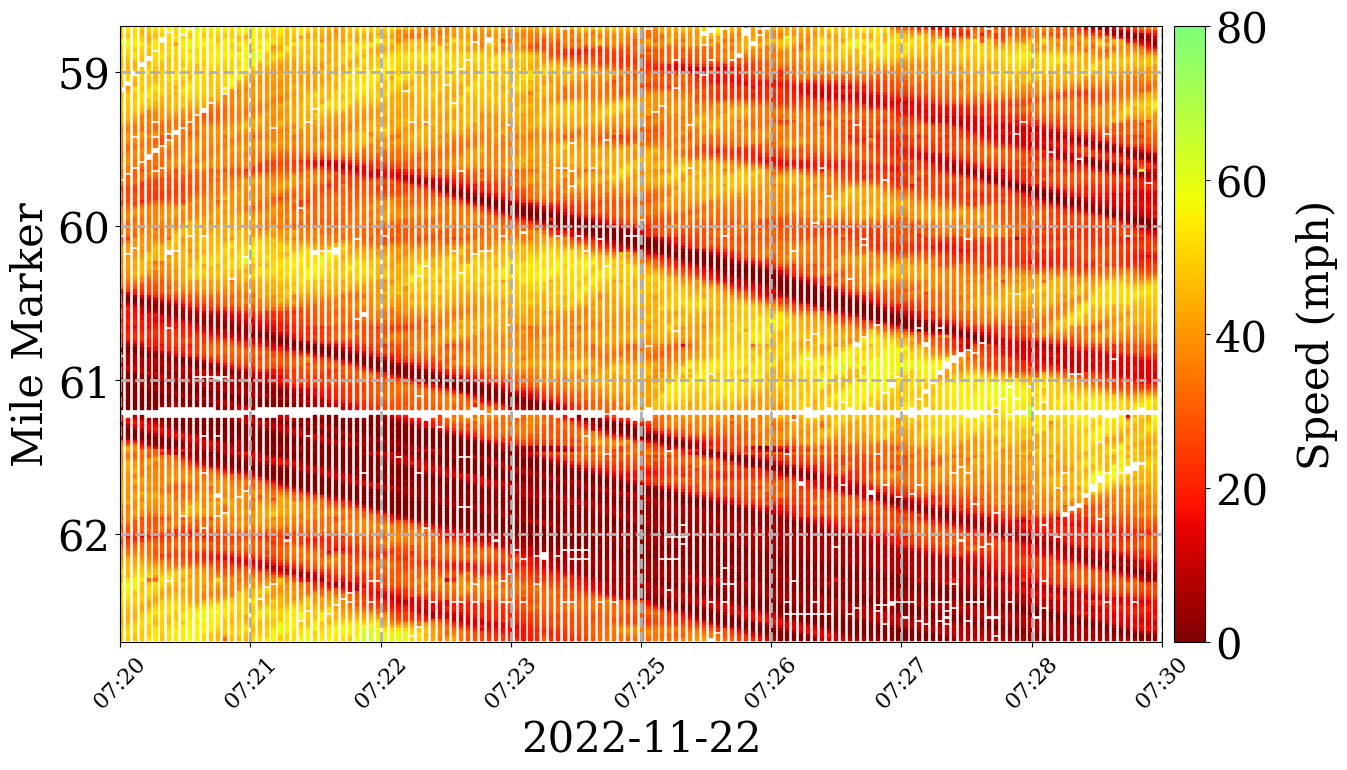

In [4]:
# Visualize the raw speed field.
visualize_heatmap(speed_raw, starttime=starttime, endtime=endtime, fig_width=16, fig_height=8, minor_xtick=int(300/dt))

# Part 2: how to smooth and interpolate the macroscopic data based on ASM?

### ASM (adaptive smoothing method)
M. Treiber, A. Kesting, and R. E. Wilson, Reconstructing the traffic state by fusion of heterogeneous data, Computer-Aided Civil and Infrastructure Engineering, vol. 26, no. 6, pp. 408–419, 2011.

<img src="figures/ASM.png" alt="ASM" width="1000"/>

In [5]:
# Import the speed field smoother and run it on the raw speed field.
from ASM import smooth_speed_field
t0 = time.time()
speed_matrix = speed_raw.pivot(index='t', columns='x', values='speed').values
smooth_speed_matrix = smooth_speed_field(speed_matrix, dx=dx, dt=dt)
print(f"Smoothing compute time: {time.time() - t0}s")

100%|██████████| 150/150 [00:02<00:00, 66.54it/s]

Smoothing compute time: 2.260596990585327s


In [6]:
# make it to a DataFrame
from macro_data_processing import matrix_to_coordinates
import pandas as pd
smooth_speed = pd.DataFrame(matrix_to_coordinates(smooth_speed_matrix))
smooth_speed.columns = ['t', 'x', 'speed']
smooth_speed['time'] = smooth_speed['t'] * dt
smooth_speed['milemarker'] = smooth_speed['x'] * dx + 58.7

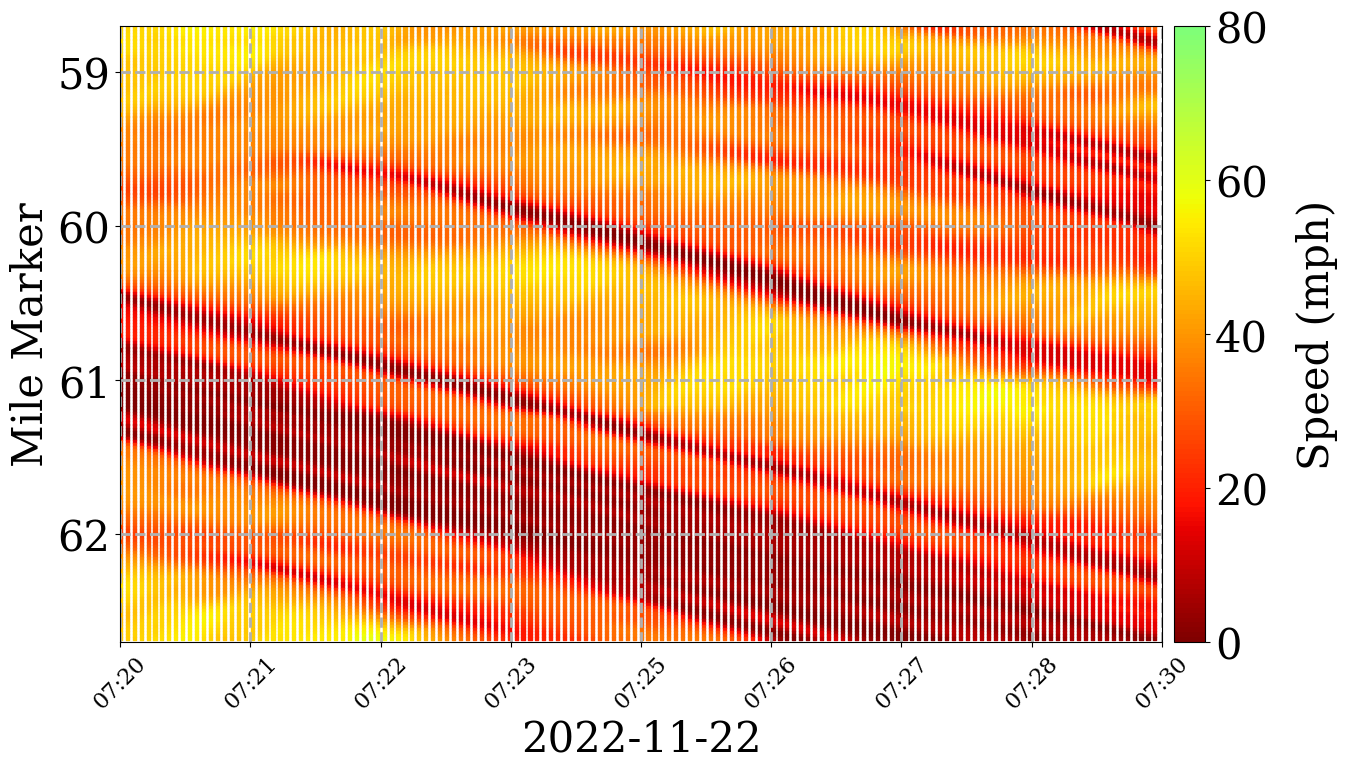

In [7]:
# Visualize the smoothed speed field.
visualize_heatmap(smooth_speed, starttime=starttime, endtime=endtime, fig_width=16, fig_height=8, minor_xtick=int(300/dt))

# Part 3: how to use the macroscopic speed field to generate VTs?

A standard approach to generate trajectories from a macroscopic speed field is to calculate the position p(t) of a vehicle assuming the velocity dynamics of the vehicle are computed as follows:
$
\frac{dp(t)}{dt} = v_S(t, p(t)).
$


In [8]:
# Import and use the function for generating a virtual trajectory through the smooth speed field.
from VT import gen_VT_k
# 'k' represents the index of the vehicle. For example, when k=1, the start time is 30 seconds; when k=2, the start time is 1 minute.
vt = gen_VT_k(smooth_speed[['time', 'milemarker', 'speed']],k=0)
# Note: the code for this function will be revised later

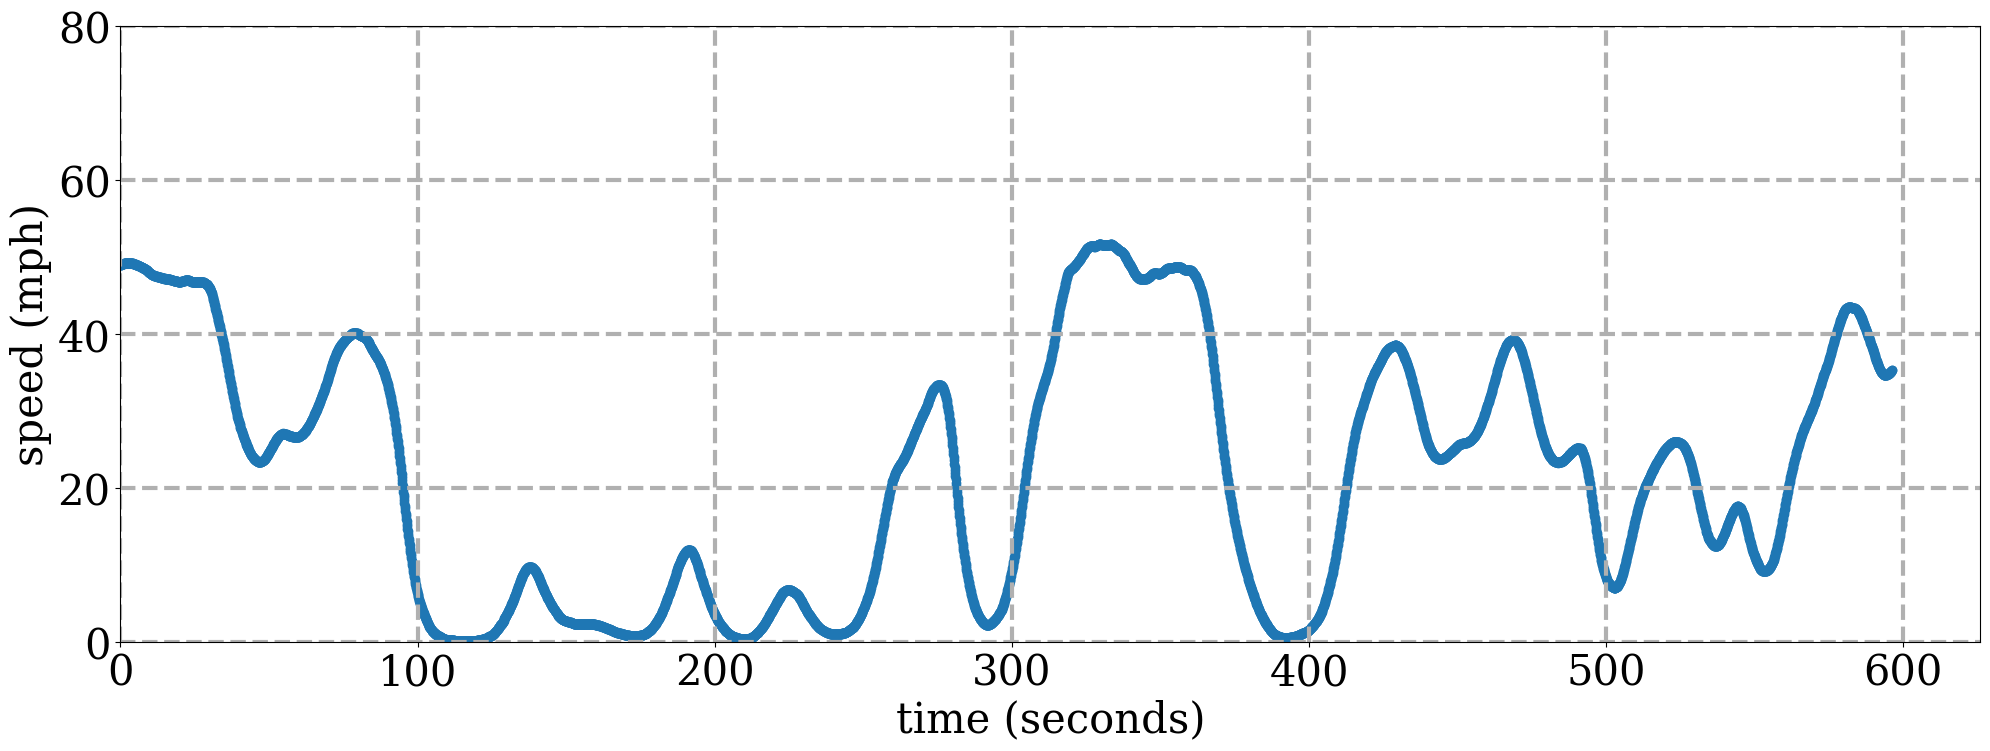

In [9]:
# Observe how the speed oscillates over time.
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 8))
plt.scatter(vt.time, vt.speed)
plt.ylim(0,80)
plt.xlim(0,)
# plt grid on
plt.grid(linestyle='--',lw=3)
plt.ylabel('speed (mph)')
plt.xlabel('time (seconds)')
plt.show()

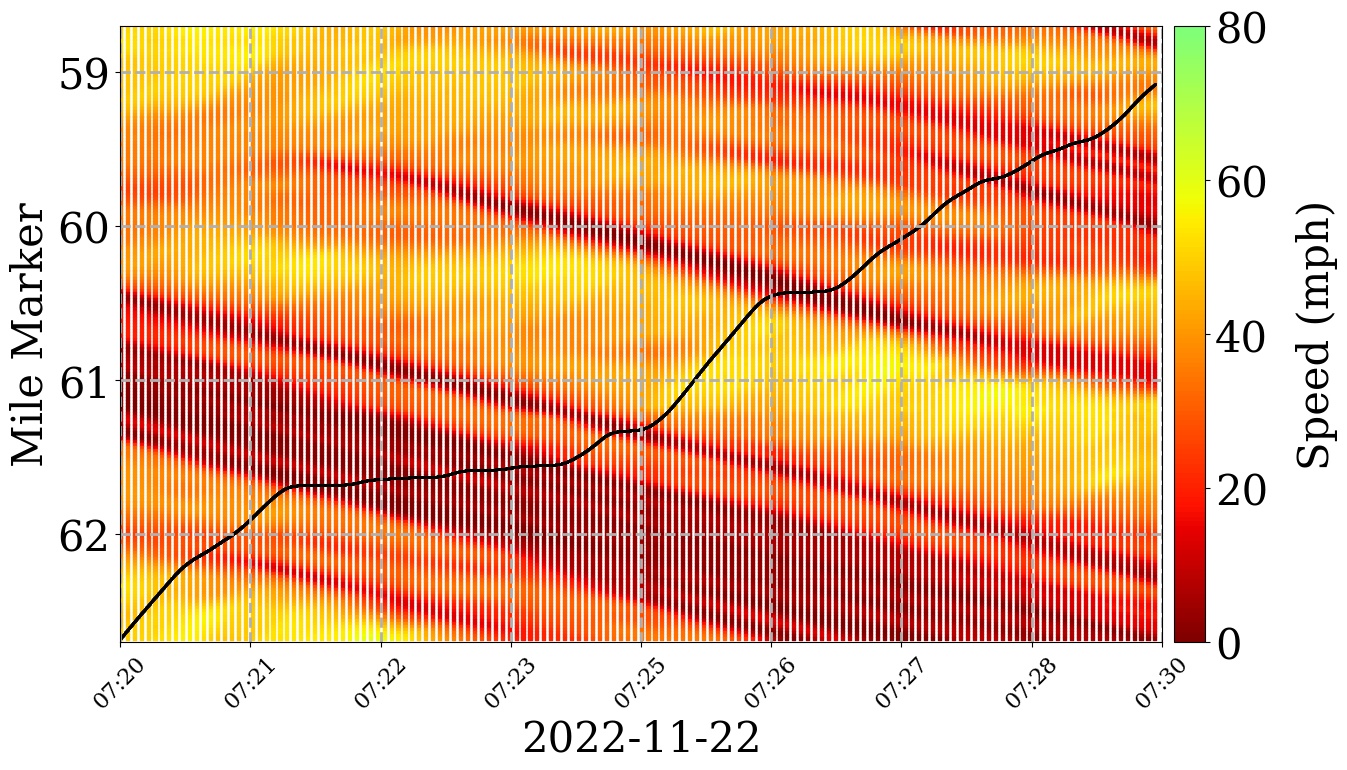

In [10]:
# Visualize the speed field with the virtual trajectory on top
from visualization import visualize_heatmap_vt
visualize_heatmap_vt(smooth_speed, vt, starttime, endtime, fig_width=16, fig_height=8, minor_xtick=int(300/dt))

More data and analysis... ***Ji, J., Wang, Y., Gloudemans, D., Zachár, G., Barbour, W., & Work, D. B. (2024, February). Virtual Trajectories for I–24 MOTION: Data and Tools. In 2024 Forum for Innovative Sustainable Transportation Systems (FISTS) (pp. 1-6). IEEE.***
<img src="figures/4lane_w_vts.png" width="1800"/>